In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import  RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay


## Starting point

This report initiates an analysis of the USSeatBelt dataset with the primary objective of identifying the most influential features for predicting a **fatalities** (number of fatalities per million of traffic miles) as a target variable.

Potential Predictor Variables:
- state - factor indicating US state (abbreviation).
- year - factor indicating year.
- miles - millions of traffic miles per year.
- seatbelt - seat belt usage rate, as self-reported by state population surveyed.
- speed65 - factor. Is there a 65 mile per hour speed limit? (yes/no)
- speed70 - factor. Is there a 70 (or higher) mile per hour speed limit? (yes/no)
- drinkage - factor. Is there a minimum drinking age of 21 years? (yes/no)
- alcohol - factor. Is there a maximum of 0.08 blood alcohol content? (yes/no)
- income - median per capita income (in current US dollar).
- age - mean age.
- enforce - factor indicating seat belt law enforcement ("no", "primary", "secondary")

This report will employ a variety of feature selection techniques, including Principal Component Analysis, feature importance scores derived from Random Forest, and Recursive Feature Selection, to evaluate the predictive power of these potential predictors. The aim is to determine the optimal subset of features for the development of a regression model.

## Data management
read data from scv

In [2]:
df = pd.read_csv('USSeatBelts.csv', sep='\\s+', quotechar='"')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   state       765 non-null    object 
 1   year        765 non-null    int64  
 2   miles       765 non-null    int64  
 3   fatalities  765 non-null    float64
 4   seatbelt    556 non-null    float64
 5   speed65     765 non-null    object 
 6   speed70     765 non-null    object 
 7   drinkage    765 non-null    object 
 8   alcohol     765 non-null    object 
 9   income      765 non-null    int64  
 10  age         765 non-null    float64
 11  enforce     765 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 71.8+ KB


There are just 1 column with missing values: *seatbelt*

In [3]:
df.head()

,state,year,miles,fatalities,seatbelt,speed65,speed70,drinkage,alcohol,income,age,enforce
0,AK,1983,3358,0.044669,NaN,no,no,yes,no,17973,28.234966,no
1,AK,1984,3589,0.037336,NaN,no,no,yes,no,18093,28.343542,no
2,AK,1985,3840,0.033073,NaN,no,no,yes,no,18925,28.372816,no
3,AK,1986,4008,0.025200,NaN,no,no,yes,no,18466,28.396652,no
4,AK,1987,3900,0.019487,NaN,no,no,yes,no,18021,28.453251,no


In [4]:
df.describe()

,year,miles,fatalities,seatbelt,income,age
count,765.00000,765.000000,765.000000,556.000000,765.000000,765.000000
mean,1990.00000,41447.734641,0.021490,0.528852,17992.586928,35.137194
std,4.32332,43961.990037,0.006171,0.170186,4811.459296,1.698131
min,1983.00000,3099.000000,0.008327,0.060000,8372.000000,28.234966
25%,1986.00000,11401.000000,0.017341,0.420000,14266.000000,34.387501
50%,1990.00000,30319.000000,0.021199,0.550000,17624.000000,35.391766
75%,1994.00000,52312.000000,0.024774,0.650000,21080.000000,36.130787
max,1997.00000,285612.000000,0.045470,0.870000,35863.000000,39.169582


## Scaling numeric variables

The numeric variables will be scaled using StandardScaler()

In [5]:

numeric_features_to_scale = ['miles', 'fatalities', 'seatbelt', 'income', 'age']

df2 = df.copy()

scaler = StandardScaler()
df2[numeric_features_to_scale] = scaler.fit_transform(df2[numeric_features_to_scale])
df2.head()


,state,year,miles,fatalities,seatbelt,speed65,speed70,drinkage,alcohol,income,age,enforce
0,AK,1983,-0.866991,3.758546,NaN,no,no,yes,no,-0.004074,-4.067261,no
1,AK,1984,-0.861733,2.569503,NaN,no,no,yes,no,0.020883,-4.003280,no
2,AK,1985,-0.856020,1.878209,NaN,no,no,yes,no,0.193917,-3.986030,no
3,AK,1986,-0.852196,0.601578,NaN,no,no,yes,no,0.098457,-3.971984,no
4,AK,1987,-0.854654,-0.324672,NaN,no,no,yes,no,0.005909,-3.938633,no


## Binary coding for categorical variables

The categorical variables will be encoded using pd.get_dummies with argument "drop_first=True" because the result table should have reasonamble number of columns in terms of smallest possible dimentionality.

In [6]:

df3 = pd.get_dummies(df2, columns=["speed65","speed70","drinkage", "alcohol", "enforce"], drop_first=True)
#df3.iloc[:,:5].head(1)
df3.head()

,state,year,miles,fatalities,seatbelt,income,age,speed65_yes,speed70_yes,drinkage_yes,alcohol_yes,enforce_primary,enforce_secondary
0,AK,1983,-0.866991,3.758546,NaN,-0.004074,-4.067261,False,False,True,False,False,False
1,AK,1984,-0.861733,2.569503,NaN,0.020883,-4.003280,False,False,True,False,False,False
2,AK,1985,-0.856020,1.878209,NaN,0.193917,-3.986030,False,False,True,False,False,False
3,AK,1986,-0.852196,0.601578,NaN,0.098457,-3.971984,False,False,True,False,False,False
4,AK,1987,-0.854654,-0.324672,NaN,0.005909,-3.938633,False,False,True,False,False,False


## Imputing missing values using k-NN

Since we already know that there are just 1 column with missing values: *seatbelt*; we will use k-NN just for this column

But first, check if these numbers are close to natural numbers

In [7]:
df['seatbelt'].unique()[0:5] ## used df here instead of df2 or df3 because the check of natural numbers on the initial dataset

array([       nan, 0.44999999, 0.66000003, 0.69      , 0.13      ])

They are not, therefore the normally scaled numbers will be real numbers.

In [8]:
imputer = KNNImputer(n_neighbors=3)

column_to_impute = df3[['seatbelt']]

imputed_values = imputer.fit_transform(column_to_impute)

imputed_series = pd.Series(imputed_values.flatten())

df3['seatbelt'] = df3['seatbelt'].fillna(imputed_series)

In [9]:
df3.head()

,state,year,miles,fatalities,seatbelt,income,age,speed65_yes,speed70_yes,drinkage_yes,alcohol_yes,enforce_primary,enforce_secondary
0,AK,1983,-0.866991,3.758546,-1.469648e-16,-0.004074,-4.067261,False,False,True,False,False,False
1,AK,1984,-0.861733,2.569503,-1.469648e-16,0.020883,-4.003280,False,False,True,False,False,False
2,AK,1985,-0.856020,1.878209,-1.469648e-16,0.193917,-3.986030,False,False,True,False,False,False
3,AK,1986,-0.852196,0.601578,-1.469648e-16,0.098457,-3.971984,False,False,True,False,False,False
4,AK,1987,-0.854654,-0.324672,-1.469648e-16,0.005909,-3.938633,False,False,True,False,False,False


The first 6 columns had no values in the *seatbelt* column, but df3 has these values. They are very close to 0, which means that this number is about 53% in the original scale of this column

## Corrplot

<Axes: >

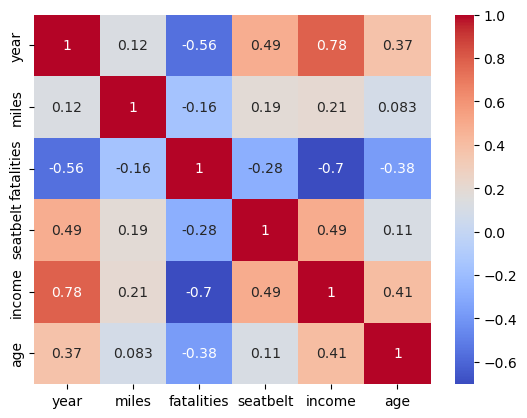

In [10]:
numeric_features = ['year','miles', 'fatalities', 'seatbelt', 'income', 'age']

sns.heatmap(df3[numeric_features].corr(),
            annot = True,
            cmap = 'coolwarm')

**Year** highly correlates with fatalities and income. Since Year has the higher correlation with other predictors, it is suggested for removal.

## PCA

As described before, the **fatalities** is considered as target variable, so it should be removed from dataset to perform Principal component analysis.

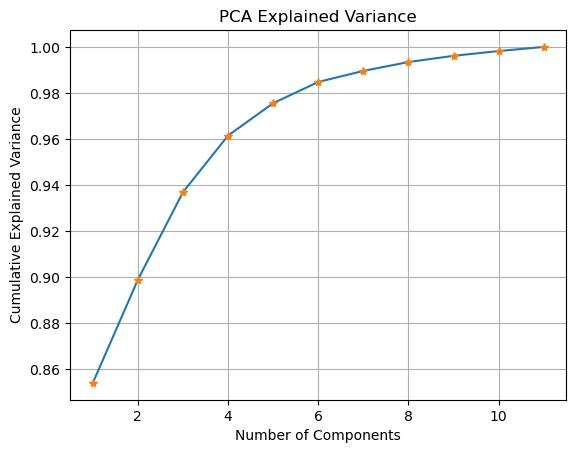

In [11]:
df4 = df3.drop(columns=['state','fatalities']) # just numeric predictors

pca = PCA()
pca.fit(df4)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = np.arange(1, len(cumulative_variance_ratio) + 1)

plt.plot(num_components, cumulative_variance_ratio)
plt.plot(num_components, cumulative_variance_ratio, '*')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

Looks like the reasonable number of component can be 2 or 3, because the cumulative explained variance for them is already almost 90% and 94% respectively. Further adding of components produce just a little additional cumulative explained variance (about 2% on next step).

90% is already great percentage, which means we can stick with 2 components. Also 2d space is the easiest to explain.

In [12]:

n_components = 2 
print(f"Explained variance with {n_components} components:", 
      np.cumsum(pca.explained_variance_ratio_)[n_components-1])

pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df4)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(n_components)],
                        index=df4.columns)

print(loadings)

Explained variance with 2 components: 0.8988825228292813
                        PC1       PC2
year               0.968821 -0.106390
miles              0.031105  0.924009
seatbelt           0.096108  0.210305
income             0.179585  0.199405
age                0.087500  0.210653
speed65_yes        0.071646 -0.041114
speed70_yes        0.021718  0.004442
drinkage_yes       0.035859  0.009912
alcohol_yes        0.017753  0.008255
enforce_primary    0.010497  0.063514
enforce_secondary  0.062921  0.024761


 **The first component** include almost the whole variable "year", and a little amount of other variables, so this component can be described as **"period of time"**

**The second component** consist of many variables with percentage of the particular variable around 20 (which are seatbelt, income and age), but the main variable in this component is *miles*, therefore this component can mainly be described as **"trafic-load"**

An interesting thing that **income** included in both components almost equaly (it highly correlated with Year).

## Feature importance scores
based on Random Forest

*A quick reminder of how it works*

1) **Out-of-Bag (OOB) Samples:** When building each decision tree in the Random Forest, a random subset of the training data is used (sampling with replacement). The data points that are not included in the training of a specific tree are called the out-of-bag (OOB) samples for that tree. These OOB samples act as an internal validation set for each tree.   

2) **Baseline Performance:** For each tree, the prediction accuracy (or the chosen metric) is evaluated on its OOB samples. This provides a baseline performance for that tree.

3) **Feature Permutation:** To assess the importance of a specific feature, say feature 'X', the values of feature 'X' are randomly shuffled only within the OOB samples of each tree. This effectively breaks the relationship between feature 'X' and the target variable for those specific OOB samples. The values of all other features remain unchanged.   

4) **Performance After Permutation:** After permuting the values of feature 'X', the prediction accuracy (or the same metric used in step 2) is again evaluated on the permuted OOB samples of each tree.

5) **Importance Calculation:** The importance of feature 'X' for a single tree is the difference between the baseline performance (step 2) and the performance after permutation (step 4). A large difference indicates that the model's performance significantly degrades when the information from feature 'X' is disrupted, implying that the feature is important for making accurate predictions.   

6) **Averaging Across Trees:** This process (steps 2-5) is repeated for each feature in the dataset. The importance score for each feature is then averaged across all the trees in the Random Forest.

7) **Normalization (Optional):** The resulting importance scores are often normalized to sum up to 1 or to a specific range, making them easier to interpret as relative contributions

 1) income                         0.598033
 2) age                            0.173089
 3) miles                          0.119355
 4) year                           0.041592
 5) seatbelt                       0.036054
 6) alcohol_yes                    0.009138
 7) speed70_yes                    0.007313
 8) enforce_secondary              0.004455
 9) drinkage_yes                   0.004385
10) speed65_yes                    0.003813
11) enforce_primary                0.002771


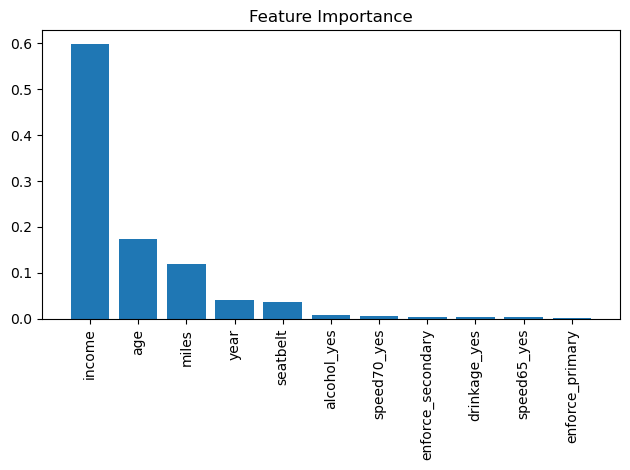

In [13]:
X = df3.drop(columns=['fatalities'])
y = df3['fatalities']

X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=['state']), y, test_size=0.2, random_state=10)

feat_labels = X_train.columns
forest = RandomForestRegressor(n_estimators=500, random_state=11)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
    feat_labels[indices[f]],
    importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
    importances[indices],
    align='center')
plt.xticks(range(X_train.shape[1]),
    feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Looks like the **income** is most important feature, showcases 0.60, whereas next important feature has just 0.17 normalized score.

Noticiable that categorical fetures placed in the end of the rating, but this behaviar is expected because this method has bias towards numerical features. But still in cases when the categorical features highly important, this method shows it.


## ICE/PDP-plots

- Individual Conditional Expectation (ICE) plots show the effect of a feature, given typical values of the others.
- Partial Dependence Plot (PDP): average of the individual ICE curves.

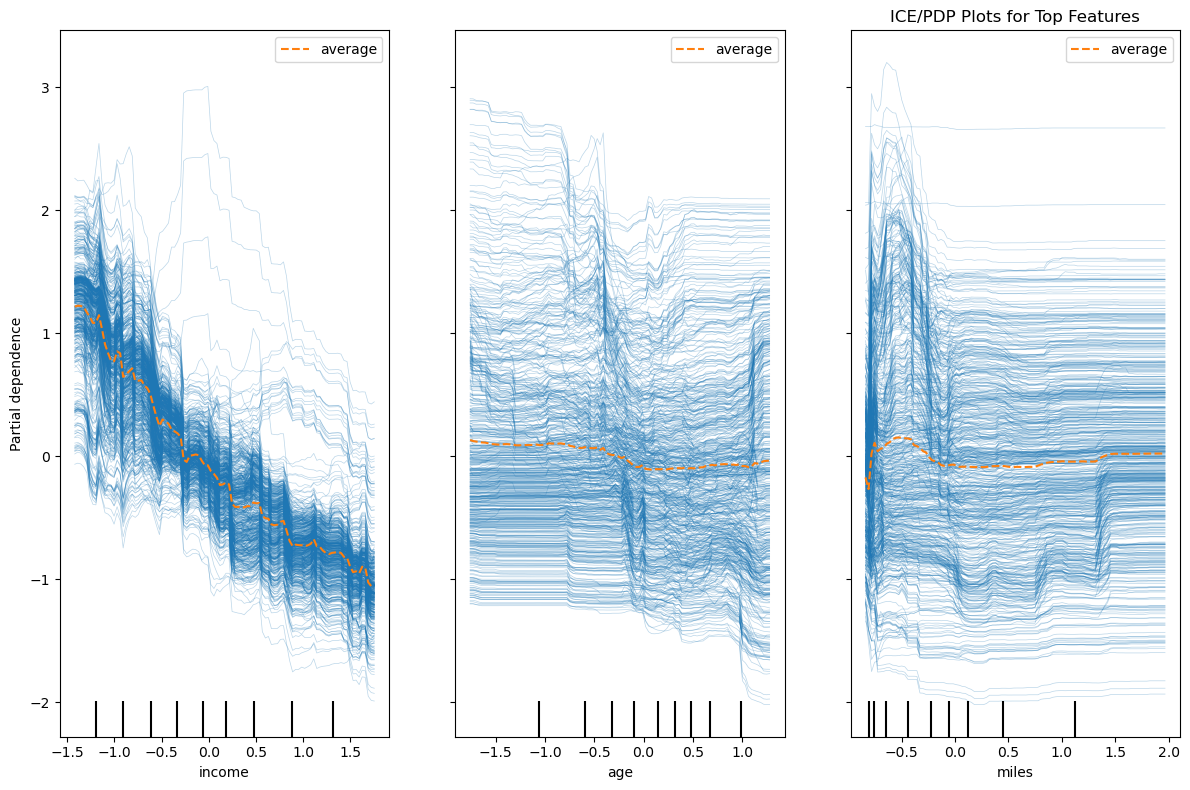

In [ ]:
importances_df = pd.DataFrame({
    'feature': feat_labels,
    'importance': importances
}).sort_values('importance', ascending=False)

top_features = importances_df['feature'].head(3).tolist()

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    forest, X_train, top_features, 
    kind='both', 
    ax=ax
)
plt.title("ICE/PDP Plots for Top Features")
plt.tight_layout()
plt.show()

The income is highly important on the whole range of it's variance

Age is almost parallel to Ox, but it has changing pattern at 0 and at 1.

Miles is influential only at the range from -1 to 0.

## Recursive feature selection

N= 10

Selected features from RFECV:
Index(['year', 'miles', 'seatbelt', 'income', 'age', 'speed65_yes',
       'speed70_yes', 'drinkage_yes', 'alcohol_yes', 'enforce_secondary'],
      dtype='object')


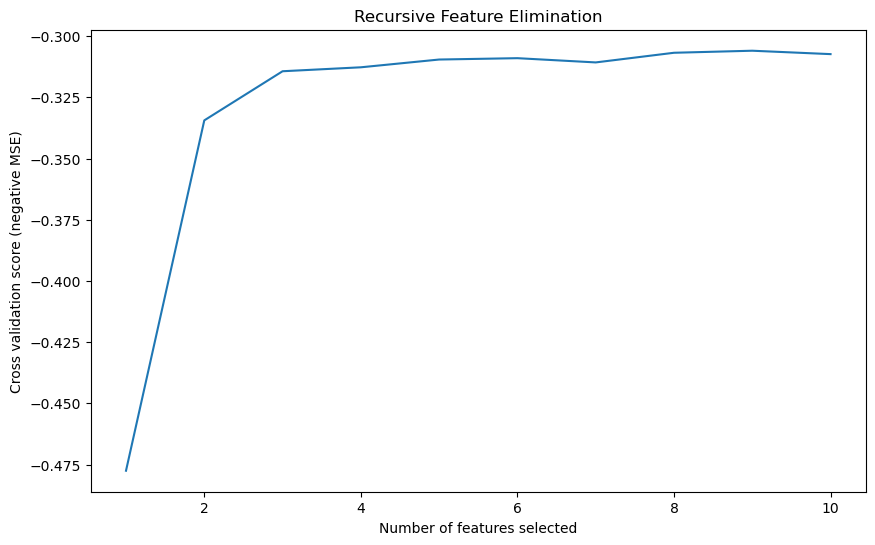

In [15]:
rfecv = RFECV(
    estimator=RandomForestRegressor(n_estimators=100, random_state=13),
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=2
)
rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
print(f"N= {len(selected_features)}")
print("\nSelected features from RFECV:")
print(selected_features)

# Plot number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (negative MSE)")
plt.title("Recursive Feature Elimination")
plt.show()


The RFECV method suggest us to include 10 variables as predictors, that means we should get rid of just 1 variable which is "enforce_primary". 

The result compariable to Feture important scores, because the later also rated the "enforce_primary" last.

But this column is a part of categorical variable as a result of one-hot-encoding, so it is meaningfull not to delete this category from the dataset.

Also, we can see that after adding 4th, 5th and so on variables we have just a little impove in terms of MSE, which means we can use just 3 predictors to perform competitively good.

## Summary

Overall, we have done all planned activities regarding feature engineering for this dataset.

The meaningful set of predictors could be:
1) Income
2) Age
3) Miles

This variables can be used to predict "fatalities".

But for better accuracy at is also possible to use all variables as predictor, because they can be valuable for some states. 